In [1]:
import pandas as pd
import os
import sys
import ta

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
pd.read_csv("../data/processed/starting_portfolio.csv")['asset'].to_list()

['CZR',
 'INTC',
 'MHK',
 'BLDR',
 'URI',
 'ON',
 'NCLH',
 'ALB',
 'VST',
 'AVAX-USD',
 'SOL-USD',
 'LINK-USD']

In [2]:
asset = 'CZR'

In [3]:
import yfinance as yf

start_date = "2024-03-01"
end_date = "2025-03-01"

prices = yf.Ticker(asset).history(start=start_date, end=end_date, actions=False)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2024-03-01 00:00:00-05:00,43.380001,43.380001,42.037998,42.959999,2846600
2024-03-04 00:00:00-05:00,42.730000,42.750000,41.520000,41.570000,3010400
2024-03-05 00:00:00-05:00,41.230000,41.980000,40.930000,41.080002,2283000
2024-03-06 00:00:00-05:00,41.930000,41.930000,40.775002,40.990002,1988600
2024-03-07 00:00:00-05:00,41.060001,42.090000,41.060001,41.689999,2071800
...,...,...,...,...,...
2025-02-24 00:00:00-05:00,35.840000,35.849998,34.580002,35.040001,4501800
2025-02-25 00:00:00-05:00,34.880001,35.349998,33.980000,34.869999,6200900
2025-02-26 00:00:00-05:00,35.790001,36.259998,34.209999,34.560001,6314400


In [4]:

def add_features(prices):
    indicators = ta.add_all_ta_features(prices, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    indicators['ema2'] = indicators['Close'].ewm(span=2, adjust=False).mean()
    indicators['ema3'] = indicators['Close'].ewm(span=3, adjust=False).mean()
    indicators['ema4'] = indicators['Close'].ewm(span=4, adjust=False).mean()
    indicators['ema5'] = indicators['Close'].ewm(span=5, adjust=False).mean()
    indicators['ema6'] = indicators['Close'].ewm(span=6, adjust=False).mean()
    indicators['ema7'] = indicators['Close'].ewm(span=7, adjust=False).mean()
    indicators['ema10'] = indicators['Close'].ewm(span=10, adjust=False).mean()
    indicators['ema20'] = indicators['Close'].ewm(span=20, adjust=False).mean()
    return indicators.copy()


In [5]:
indicators = add_features(prices)

c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [6]:
indicators.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

In [7]:
target = indicators['Close'].iloc[:-1] - indicators['Close'].shift(-1).iloc[:-1]
indicators = indicators.iloc[:-1]

In [8]:
import yfinance as yf

start_date = "2025-02-01"
end_date = "2025-04-01"

real_prices = yf.Ticker(asset).history(start=start_date, end=end_date, actions=False)

real_indicators = add_features(real_prices)
real_change = real_indicators['Close'].iloc[:-1] - real_indicators['Close'].shift(-1).iloc[:-1]
real_indicators = real_indicators.iloc[:-1]

c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [9]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

common_index = indicators.index.intersection(target.index)
X = indicators.loc[common_index]
y = target.loc[common_index]

def objective(trial):
    params = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 5e-3, 5e-2, log=True),
        "max_depth": trial.suggest_int("max_depth", 6, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 3),
        "subsample": trial.suggest_float("subsample", 0.9, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.9, 1.0, step=0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 1200, step=100),
        "tree_method": "hist",
    }

    model = xgb.XGBRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=3)

    cv_scores = cross_val_score(
        model,
        X,
        y,
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    
    mse = -1.0 * np.mean(cv_scores)
    return mse


c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best trial:")
print("  Value (MSE):", study.best_trial.value)
print("  Params:", study.best_trial.params)

[I 2025-04-05 19:04:21,716] A new study created in memory with name: no-name-9929a1fc-6a2d-402b-9d22-7c26bd0e5417
[I 2025-04-05 19:04:37,504] Trial 5 finished with value: -0.2206052016231129 and parameters: {'learning_rate': 0.03937298500312631, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 0.9, 'n_estimators': 1200}. Best is trial 5 with value: -0.2206052016231129.
[I 2025-04-05 19:04:38,206] Trial 13 finished with value: -0.21573638503401316 and parameters: {'learning_rate': 0.033960373640657196, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'n_estimators': 1200}. Best is trial 5 with value: -0.2206052016231129.
[I 2025-04-05 19:04:40,865] Trial 15 finished with value: -0.2118297907457402 and parameters: {'learning_rate': 0.013839806020998399, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'n_estimators': 1000}. Best is trial 5 with value: -0.2206052016231129.
[I 2025-04-05 19:04:41,

Best trial:
  Value (MSE): -0.27442889533000747
  Params: {'learning_rate': 0.04392130609945611, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'n_estimators': 1200}


In [11]:
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y)
y_pred = final_model.predict(real_indicators)


In [12]:
np.corrcoef(y_pred, real_change.values)[0, 1]

0.1214276797792978

In [13]:
sum((y_pred > 2) == (real_change.values > 2)) / len(real_change)

0.9743589743589743

In [14]:
import os
os.makedirs("../data/processed/xgb", exist_ok=True)
final_model.save_model(f"../data/processed/xgb/{asset}.json")

In [15]:
df = pd.DataFrame(real_change)
df['predicted_change'] = y_pred

In [16]:
real_indicators[real_indicators.index >= '2025-03-01'].head(3)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,others_dlr,others_cr,ema2,ema3,ema4,ema5,ema6,ema7,ema10,ema20
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-03 00:00:00-05:00,33.610001,34.220001,31.370001,31.469999,6571100,-7.173242e+06,-40541000,-0.075880,-3.086231e+06,-18.216093,...,-5.411745,-11.426962,32.111334,32.567394,32.959300,33.307616,33.614160,33.880224,34.472313,35.281787
2025-03-04 00:00:00-05:00,30.870001,31.420000,29.270000,30.730000,7589000,-4.455325e+06,-48130000,-0.064515,-3.447607e+06,-69.409681,...,-2.379533,-13.509708,31.190444,31.648697,32.067580,32.448411,32.790114,33.092668,33.791892,34.848283
2025-03-05 00:00:00-05:00,30.820000,31.320000,29.770000,30.370001,7140900,-6.067780e+06,-55270900,-0.100032,-3.322336e+06,4.341183,...,-1.178405,-14.522933,30.643482,31.009349,31.388548,31.755607,32.098653,32.412001,33.169730,34.421780


In [17]:
df[df.index >= '2025-03-01']

,Close,predicted_change
Date,,
2025-03-03 00:00:00-05:00,0.740000,-2.018025
2025-03-04 00:00:00-05:00,0.359999,-1.774708
2025-03-05 00:00:00-05:00,1.460001,-1.957361
2025-03-06 00:00:00-05:00,0.430000,-2.041773
2025-03-07 00:00:00-05:00,1.219999,-1.828520
2025-03-10 00:00:00-04:00,-0.580000,-1.987070
2025-03-11 00:00:00-04:00,0.520000,-1.924230
2025-03-12 00:00:00-04:00,0.690001,-1.660953
2025-03-13 00:00:00-04:00,-1.440001,-1.796651


In [18]:
TP = sum((y_pred > 0) == (real_change.values > 0))
FP = sum((y_pred > 0) != (real_change.values > 0))
TN = sum((y_pred < 0) == (real_change.values < 0))
FN = sum((y_pred < 0) != (real_change.values < 0))
TP / (TP + FN)


0.4358974358974359

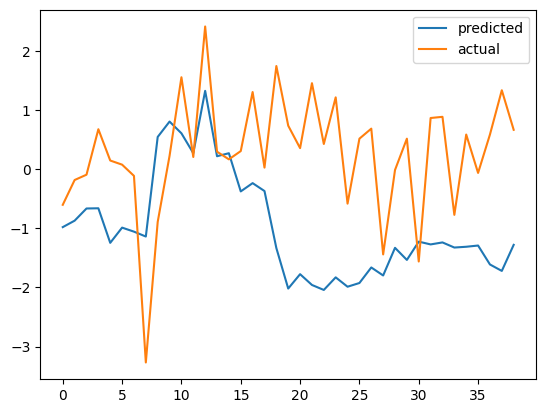

In [19]:
import matplotlib.pyplot as plt

plt.plot(y_pred)
plt.plot(real_change.values)
plt.legend(['predicted', 'actual'])
plt.show()
